# Explore the data in a GRDC day file

In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

### Read in station data from a folder containing the GRDC files, using the station identifier.

In [2]:
## Open the file, skip the metadata and plot the daily data

def dataframe_from_stationId(grdc_folder, station_id):
    ''' Search the grdc_folder for a file with name <station_id>.day,
    skip the header rows and return the dates and discharges in a dataframe'''
    filename = str(station_id) + ".day"
    grdc_file = os.path.join(grdc_folder, filename)

    grdc_data = pd.read_csv(grdc_file, skiprows=40, delimiter=';')
    grdc_data = grdc_data.rename(columns={'YYYY-MM-DD': 'date', ' Original': 'discharge'})
    grdc_data = grdc_data.reset_index().set_index(pd.DatetimeIndex(grdc_data['date']))
    grdc_data = grdc_data[['date', 'discharge']]
    
    return grdc_data

my_grdc_folder = "D:\sbranchett\Jerom\GRDCdat_day"
my_stations = ["mytest", 6196700, 1445500, 5202150]

grdc_dataframes = {}
for station in my_stations:
    grdc_dataframes[station] = dataframe_from_stationId(my_grdc_folder, station)
#grdc_dataframes

### Missing data is set to -999, so these are easily visible as large negative values of discharge.

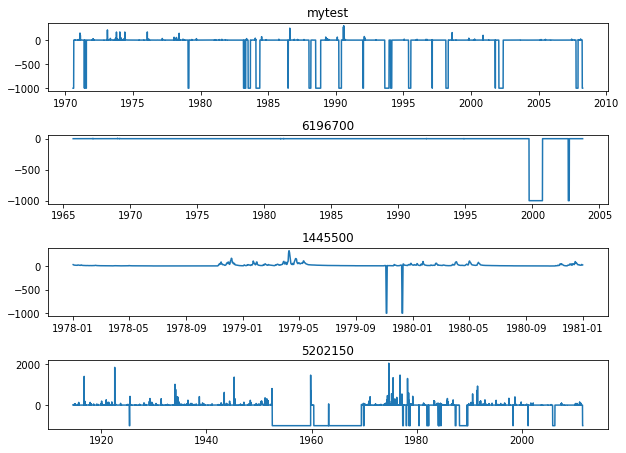

In [3]:
no_plots = len(grdc_dataframes)
fig, axs = plt.subplots(no_plots, 1, figsize=(8.8, 1.6*no_plots))

if no_plots == 1:
    plt.plot(grdc_dataframe.drop(columns=['date']))
elif no_plots > 1:
    subplot_index = 0
    for idx, grdc_dataframe in grdc_dataframes.items():
        axs[subplot_index].plot(grdc_dataframe.drop(columns=['date']))
        axs[subplot_index].set_title(idx)
        subplot_index += 1

plt.tight_layout()

### Make a dataframe containing valid discharge values for all the stations of interest

In [4]:
init = True
for idx, grdc_dataframe in grdc_dataframes.items():
    if init:
        combined = grdc_dataframe.drop(columns=['date']).rename(columns={'discharge': 'discharge_'+str(idx)})
        init = False
    else:
        combined = pd.merge(combined, grdc_dataframe.drop(columns=['date']), how='outer', on='date',
                            sort=True)
        combined = combined.rename(columns={'discharge': 'discharge_'+str(idx)})

combined = combined.replace(-999., np.nan)
cleaned = combined.dropna(axis=0, how='any')
cleaned

,discharge_mytest,discharge_6196700,discharge_1445500,discharge_5202150
date,,,,
1978-01-12,0.005,0.0,29.0,1.290
1978-01-13,0.005,0.0,26.0,1.134
1978-01-14,0.009,0.0,24.0,1.015
1978-01-15,0.018,0.0,23.0,0.929
1978-01-16,59.939,0.0,22.0,1.218
1978-01-17,5.217,0.0,22.0,1.212
1978-01-18,7.519,0.0,30.0,1.124
1978-01-19,19.173,0.0,28.0,1.300
1978-01-20,4.316,0.0,23.0,1.351


### Make series with valid data and consecutive dates

How many days may have data problems?

Specify the number of consecutive days in a series that may have invalid data.

Each station is evulated separately.

Default is 0.

In [5]:
num_invalid_days = 3

In [6]:
def valid_series(cleaned, num_invalid_days=0):
    ''' Search through a combined, cleaned and sorted dataframe and return a dataframe with start
    end dates of series with consecutive days of valid discharge data.
    num_invalid_days is the number of consecutive days in a series that may contain invalid data. '''

    series = pd.DataFrame(columns=['Start Date', 'End Date', 'Number of days in series'])

    init = True
    for index, row in cleaned.iterrows():
        date = datetime.strptime(str(index), "%Y-%m-%d %H:%M:%S")
        if init:
            start_date = date
            end_date = date
            init = False
        elif ((date - end_date).days <= num_invalid_days+1):
            # one day apart, extend set
            end_date = date
        else:  # end the current series
            series_length = (end_date - start_date).days
            if (series_length > 0):
                series = series.append({'Start Date': start_date,
                          'End Date': end_date,
                          'Number of days in series': series_length}, ignore_index=True)
            start_date = date
            end_date = start_date
            
    # end the final series
    series_length = (end_date - start_date).days
    if (series_length > 0): # 
        series = series.append({'Start Date': start_date, 'End Date': end_date,
                                'Number of days in series': series_length}, ignore_index=True)
    return series
series = valid_series(cleaned, num_invalid_days)
print(series)

  Start Date   End Date Number of days in series
0 1978-01-12 1978-06-18                      157
1 1978-07-06 1978-08-28                       53
2 1978-09-14 1979-01-27                      135
3 1979-02-20 1980-05-13                      448
4 1980-05-30 1980-12-31                      215


### Select the index of the series you wish to use

In [7]:
series_idx = 3

In [8]:
start_date = series.loc[series_idx, "Start Date"]
end_date = series.loc[series_idx, "End Date"]

series_combined = combined.loc[start_date:end_date] # combined still has the invalid values
series_cleaned = cleaned.loc[start_date:end_date] # cleaned only has the rows (dates) with valid data
# Note that if num_invalid_days has the default value of 0, series_combined and series_cleaned
# should be the same

series_combined[pd.isna(series_combined).any(axis=1)] # inspect the problem rows

,discharge_mytest,discharge_6196700,discharge_1445500,discharge_5202150
date,,,,
1979-11-05,0.456,0.0,NaN,1.404
1979-11-06,0.379,0.0,NaN,1.579
1979-12-09,0.194,0.0,NaN,0.761
1979-12-10,0.111,0.0,NaN,0.744


### Do you want to replace the problem data with values calculated by linear interpolation of closest valid data?

In [9]:
interpolate = True

In [10]:
series_combined['1979-11-03':'1979-11-09']

,discharge_mytest,discharge_6196700,discharge_1445500,discharge_5202150
date,,,,
1979-11-03,0.173,0.0,16.0,1.293
1979-11-04,1.873,0.0,17.0,1.375
1979-11-05,0.456,0.0,NaN,1.404
1979-11-06,0.379,0.0,NaN,1.579
1979-11-07,0.290,0.0,15.0,1.606
1979-11-08,0.234,0.0,18.0,1.567
1979-11-09,0.238,0.0,14.0,1.616


In [11]:
series_combined['1979-12-06':'1979-12-11']

,discharge_mytest,discharge_6196700,discharge_1445500,discharge_5202150
date,,,,
1979-12-06,0.465,0.0,27.0,0.858
1979-12-07,0.368,0.0,25.0,0.801
1979-12-08,0.277,0.0,23.0,0.779
1979-12-09,0.194,0.0,NaN,0.761
1979-12-10,0.111,0.0,NaN,0.744
1979-12-11,0.053,0.0,47.0,0.743


In [12]:
# todo what about if the dates aren't consecutive (all stations miss dates)?
def fill_nans(value_before, value_after, num_vals):
    vals = []
    delta = (value_after - value_before) / (num_vals + 1)
    for i in range (num_vals):
        vals.append(value_before + ((i + 1) * delta))
    return vals

def replace_nans(original):
    interpolated = original.copy()
    for column in original:
        # for each station in turn, look for the invalid discharge values
        init = True
        interp_zone = False
        for index, value in original[column].iteritems():
            if init:
                assert(not np.isnan(value))
                # the first row should be valid as should the last
                low_idx = index
                low_val = value
                init = False
            elif (interp_zone):
                # in a NaN zone,
                # looking for the next valid value so it is possible to interpolate
                if (np.isnan(value)):
                    pass # already in a NaN zone before we got here
                else:
                    high_idx = index
                    high_val = value
                    fill_values = (fill_nans(low_val, high_val, (high_idx - low_idx).days - 1))
                    interpolated.loc[(low_idx + pd.Timedelta(days=1)):
                                     (high_idx - pd.Timedelta(days=1)), column] = fill_values
                    low_idx = index
                    low_val = value
                    interp_zone = False
            else:
                # in a valid value zone, checking for NaNs
                if (np.isnan(value)):
                    interp_zone = True
                else:
                    low_idx = index
                    low_val = value
    return interpolated

interpolated = replace_nans(series_combined)

In [13]:
series_combined['1979-11-03':'1979-11-09']

,discharge_mytest,discharge_6196700,discharge_1445500,discharge_5202150
date,,,,
1979-11-03,0.173,0.0,16.0,1.293
1979-11-04,1.873,0.0,17.0,1.375
1979-11-05,0.456,0.0,NaN,1.404
1979-11-06,0.379,0.0,NaN,1.579
1979-11-07,0.290,0.0,15.0,1.606
1979-11-08,0.234,0.0,18.0,1.567
1979-11-09,0.238,0.0,14.0,1.616


In [14]:
interpolated['1979-11-03':'1979-11-09']

,discharge_mytest,discharge_6196700,discharge_1445500,discharge_5202150
date,,,,
1979-11-03,0.173,0.0,16.000000,1.293
1979-11-04,1.873,0.0,17.000000,1.375
1979-11-05,0.456,0.0,16.333333,1.404
1979-11-06,0.379,0.0,15.666667,1.579
1979-11-07,0.290,0.0,15.000000,1.606
1979-11-08,0.234,0.0,18.000000,1.567
1979-11-09,0.238,0.0,14.000000,1.616


In [15]:
series_combined['1979-12-06':'1979-12-11']

,discharge_mytest,discharge_6196700,discharge_1445500,discharge_5202150
date,,,,
1979-12-06,0.465,0.0,27.0,0.858
1979-12-07,0.368,0.0,25.0,0.801
1979-12-08,0.277,0.0,23.0,0.779
1979-12-09,0.194,0.0,NaN,0.761
1979-12-10,0.111,0.0,NaN,0.744
1979-12-11,0.053,0.0,47.0,0.743


In [16]:
interpolated['1979-12-06':'1979-12-11']

,discharge_mytest,discharge_6196700,discharge_1445500,discharge_5202150
date,,,,
1979-12-06,0.465,0.0,27.0,0.858
1979-12-07,0.368,0.0,25.0,0.801
1979-12-08,0.277,0.0,23.0,0.779
1979-12-09,0.194,0.0,31.0,0.761
1979-12-10,0.111,0.0,39.0,0.744
1979-12-11,0.053,0.0,47.0,0.743
